<a href="https://colab.research.google.com/github/AhmedHossam10/Ahmed_Master/blob/main/CNN_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN for Facial Expression Recognition (FER)

In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 KB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.5.3


### import Liberaries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import keras.backend as K


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKerasTF
from sklearn.model_selection import KFold


from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.2


In [58]:
print(os.listdir("./sample_data"))

['anscombe.json', 'README.md', '.ipynb_checkpoints', 'test_csv.csv', 'mnist_train_small.csv', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_test.csv']


In [57]:
data = pd.read_csv('./sample_data/train_csv.csv')
#check data shape
data.shape


# /content/sample_data/train_csv.csv

(125, 2)

### preview first 5 row of data

In [ ]:
data.head(5)

### check target labels

In [41]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
emotion_counts = data['label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['label', 'number']
emotion_counts['label'] = emotion_counts['label'].map(emotion_map)
emotion_counts

,label,number
0,Happy,7060
1,Neutral,7702
2,Fear,6967
3,Sad,7559
4,Digust,7121
5,Angry,6831
6,Surprise,8175


### Plotting a bar graph of the class distributions

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


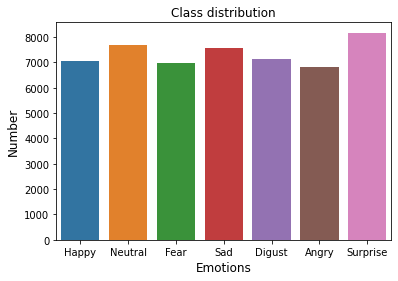

In [43]:

plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.label, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

### look at some images

In [44]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['label']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

<ipython-input-44-cef57ef6523a>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


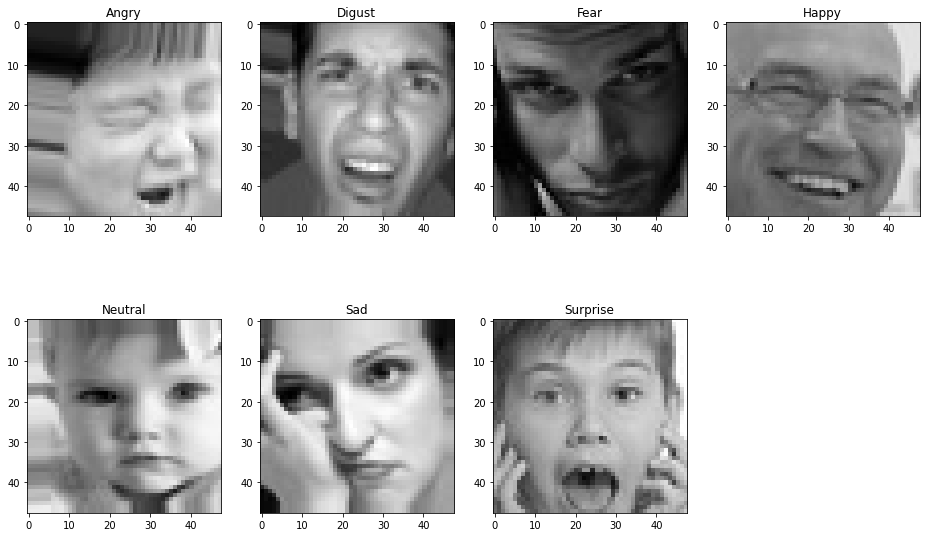

In [45]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['label'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

### initilize parameters

In [46]:
BATCH_SIZE = 16
NUM_CLASSES = 7
EPOCHS = 200
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 0.001
IMAGE_SIZE = 48

### ImageDataGenerator variable

In [47]:
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2

### Extract X, Y data from csv file

In [48]:
def get_data(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,IMAGE_SIZE, IMAGE_SIZE,1)/255.0   
    data_Y = to_categorical(df['label'], NUM_CLASSES)
    print("Data X Shape: {},", "Data Y Shape: {}".format(data_X.shape, data_Y.shape) ) 
    return data_X, data_Y

In [ ]:
X, Y = get_data(data)

### split data between training and validation

In [ ]:
x,y = shuffle(X,Y, random_state=2)

## Creating Model

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(64, (5, 5), padding='same', input_shape=(48, 48,3)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, (5, 5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (5, 5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, (5, 5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_1.add(Dropout(0.25))

model_1.add(Flatten())

model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(128))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.25))

model_1.add(Dense(NUM_CLASSES, activation='softmax'))


model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        4864      
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 48, 48, 64)       

### Compile Model

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model_1.compile(loss=LOSS_FUNCTION, optimizer = Adam(LEARNING_RATE), metrics=['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,])

### Model Visualization

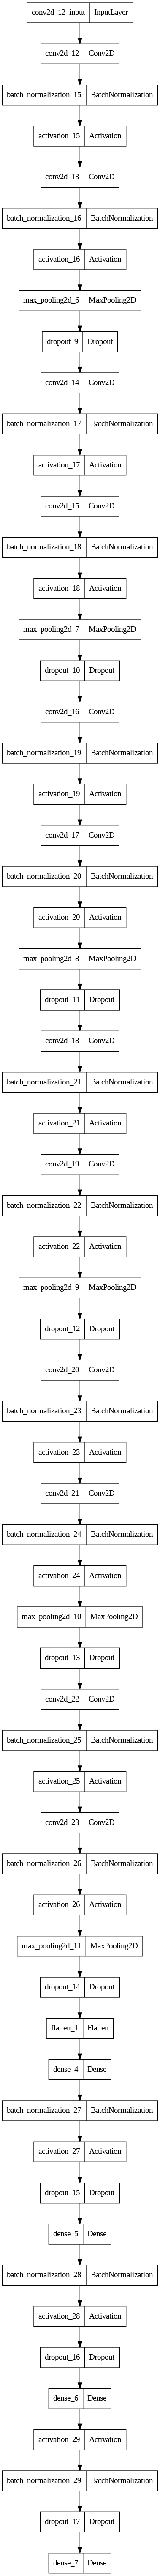

In [ ]:
plot_model(model_1, to_file='model.png')

### Define Callbacks

In [ ]:
# Callback to save Model
checkpoint = ModelCheckpoint(
    "model_weights.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Callback to early stopping of Training
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode="min",
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# Callback to reduce Learning Rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode="min",
    factor=0.5,
    patience=7,
    min_lr=1e-8,
    verbose=1,
)

callbacks = [
    PlotLossesKerasTF(),
    early_stopping,
    lr_scheduler,
    checkpoint,
]

### k-Fold Cross-Validation

In [ ]:
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
train_data_generator = ImageDataGenerator(
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range = ROTATION_RANGE,
                            width_shift_range = WIDTH_SHIFT_RANGE,
                            height_shift_range = HEIGHT_SHIFT_RANGE,
                            shear_range = SHEAR_RANGE,
                            zoom_range = ZOOM_RANGE,
                            fill_mode='nearest',
                            horizontal_flip = True)

## Training Model

In [ ]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train = x[train_index]
    Y_Train = y[train_index]
    X_Test = x[test_index]
    Y_Test = y[test_index]

    file_path = "./sample_data/weights_best_"+str(k_no)+".hdf5"
    # Callback to save Model
    checkpoint = ModelCheckpoint(
        file_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Callback to early stopping of Training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode="min",
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )

    # Callback to reduce Learning Rate
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        mode="min",
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
    )

    callbacks = [
        PlotLossesKerasTF(),
        early_stopping,
        lr_scheduler,
        checkpoint,
    ]


    history_1 = model_1.fit_generator(
        train_data_generator.flow(X_Train, Y_Train, BATCH_SIZE),
        steps_per_epoch=len(X_Train) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_Test, Y_Test),
        callbacks=callbacks,
        verbose=0)
    
    model_1.load_weights(file_path)
    result.append(model_1.predict(X_Test))
    score = model_1.evaluate(X_Test,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1